<a href="https://colab.research.google.com/github/dsantiago/Keras/blob/master/Plate%20Detection/Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dsantiago/Keras/blob/master/Plate%20Detection/Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Plate Detection

This notebook is composed by 2 parts:

1.   Detect license plate from the **Indian_Number_plate** labeled dataset via CNN
2.   After extracted the ROI, just apply **tesseract-ocr** to convert image to text
---

In [52]:
!pip install -q "tqdm>=4.36.1"
!pip install pytesseract
!wget https://raw.githubusercontent.com/dsantiago/Keras/master/Plate%20Detection/Indian_Number_plates.json
!mkdir -p images/
!apt-get install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=bed97f02bb341e1dc217886dc19b9d214f0bab434dc881534a9d4ff92c0c5ef3
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract
--2020-06-07 18:06:35--  https://raw.githubusercontent.com/dsantiago/Keras/master/Plate%20Detection/Indian_Number_plates.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92470 (90K) [text/plain]
Saving to: ‘Indian_Number_plates.json.1’

Indian_Number_plate 100%[===================>]  90.30K  --.-KB/s    in 0.02s   

2020-06-07 18:06:35 (4.92 MB/s) - ‘Indian_Number_plates.json.1’ saved [92470/92470]

Reading package lists... Done
Building dependency tree       
Re

In [0]:
import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [9]:
df = pd.read_json("Indian_Number_plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [10]:
df['image_name'] = 'license_plate_' + (df.index + 1).astype(str).str.zfill(3) + '.jpeg'

df2 = df.annotation.apply(lambda x: pd.Series({
    'top_x': x[0]['points'][0]['x'],
    'top_y': x[0]['points'][0]['y'],
    'bottom_x': x[0]['points'][1]['x'],
    'bottom_y': x[0]['points'][1]['y'],
    'width': x[0]['imageWidth'],
    'height': x[0]['imageHeight']
}))

df = pd.concat([df[['image_name', 'content']], df2], axis=1)
df.head()

,image_name,content,top_x,top_y,bottom_x,bottom_y,width,height
0,license_plate_001.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.722084,0.587983,0.868486,0.688841,806.0,466.0
1,license_plate_002.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.161943,0.850780,0.582996,1.000000,494.0,449.0
2,license_plate_003.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.082000,0.697452,0.230000,0.828025,500.0,314.0
3,license_plate_004.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.434000,0.667377,0.718000,0.765458,500.0,469.0
4,license_plate_005.jpeg,http://com.dataturks.a96-i23.open.s3.amazonaws...,0.208791,0.390764,0.865135,0.984014,1001.0,563.0


In [11]:
pbar = tqdm(df.index)

for i in pbar:
    pbar.set_description('Loading Images')
    image_name, content = df.iloc[i].image_name, df.iloc[i].content
    os.system(f"curl -o images/{image_name} {content}")

Loading Images: 100%|██████████| 237/237 [01:21<00:00,  2.92it/s]


In [0]:
test_samples = np.random.choice(df.index, 5, replace=False)

df_test = df.iloc[test_samples].reset_index(drop=True)
df_train = df.drop(test_samples, axis=0).reset_index(drop=True)

In [0]:
SIZE = 224 # VGG Input is 224x224x3

def show_plate(idx):
    image = cv2.imread(f'images/{df_train.image_name[idx]}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(SIZE, SIZE)) # VGG Input

    tx = int(df_train.top_x[idx] * SIZE)
    ty = int(df_train.top_y[idx] * SIZE)
    bx = int(df_train.bottom_x[idx] * SIZE)
    by = int(df_train.bottom_y[idx] * SIZE)
    
    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 255, 0), 1)
    
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(df_train.image_name[idx])
    plt.imshow(image)
    plt.show()

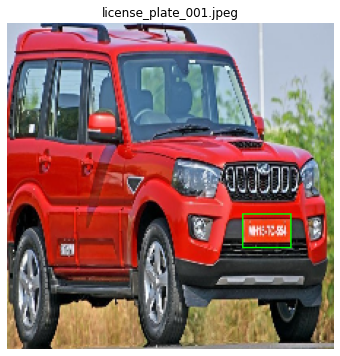

In [16]:
show_plate(0)

In [17]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df_train,
    directory='images/',
    x_col='image_name',
    y_col=['top_x', 'top_y', 'bottom_x', 'bottom_y'],
    target_size=(SIZE, SIZE),
    batch_size=32, 
    class_mode='other',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    df_train,
    directory='images/',
    x_col='image_name',
    y_col=['top_x', 'top_y', 'bottom_x', 'bottom_y'],
    target_size=(SIZE, SIZE),
    batch_size=32, 
    class_mode='other',
    subset='validation'
)

Found 209 validated image filenames.
Found 23 validated image filenames.


In [22]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
__________________________________

In [23]:
STEP_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step:", STEP_TRAIN)
print("Validation step:", STEP_VAL)

train_generator.reset()
validation_generator.reset()

Train step: 7
Validation step: 1


In [0]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='MSE')
# es = keras.callbacks.EarlyStopping(patience=10, mode='min')

In [47]:
history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=STEP_TRAIN,
    validation_steps=STEP_VAL,
    # callbacks=[es],
    epochs=40)

Epoch 1/40
7/7 [==============================] - 2s 231ms/step - loss: 5.0289e-05 - val_loss: 0.0123
Epoch 2/40
7/7 [==============================] - 2s 225ms/step - loss: 4.9644e-05 - val_loss: 0.0125
Epoch 3/40
7/7 [==============================] - 2s 231ms/step - loss: 4.1215e-05 - val_loss: 0.0125
Epoch 4/40
7/7 [==============================] - 2s 215ms/step - loss: 3.3560e-05 - val_loss: 0.0124
Epoch 5/40
7/7 [==============================] - 2s 236ms/step - loss: 2.7794e-05 - val_loss: 0.0125
Epoch 6/40
7/7 [==============================] - 2s 239ms/step - loss: 2.6133e-05 - val_loss: 0.0124
Epoch 7/40
7/7 [==============================] - 2s 238ms/step - loss: 2.2563e-05 - val_loss: 0.0126
Epoch 8/40
7/7 [==============================] - 2s 238ms/step - loss: 2.1575e-05 - val_loss: 0.0124
Epoch 9/40
7/7 [==============================] - 2s 234ms/step - loss: 2.1314e-05 - val_loss: 0.0125
Epoch 10/40
7/7 [==============================] - 2s 230ms/step - loss: 1.7575e-0

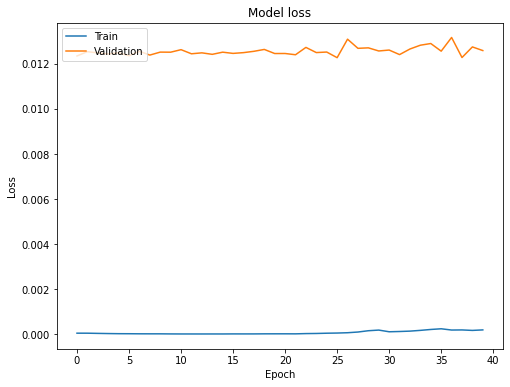

In [48]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
model.evaluate(validation_generator, steps=STEP_VAL)

1/1 [==============================] - 0s 1ms/step - loss: 0.0126


0.012588498182594776

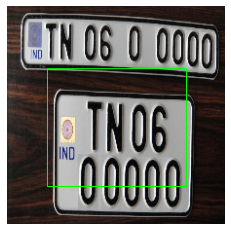

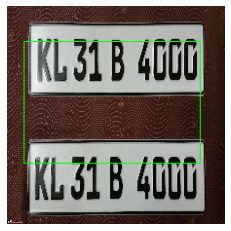

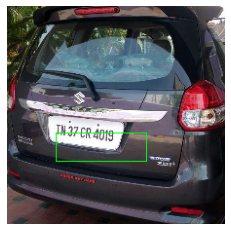

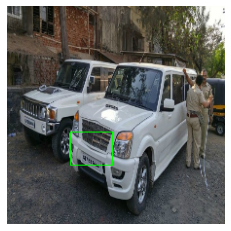

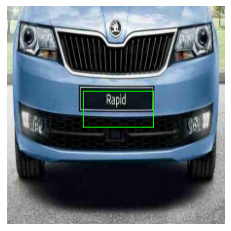

In [53]:
for name in df_test.image_name:    
    img = cv2.resize(cv2.imread("images/" + name), dsize=(SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    y_hat = model.predict(img.reshape(1, SIZE, SIZE, 3) / 255)[0] * SIZE
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 255, 0), 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [0]:
import pytesseract
from pytesseract import Output
from PIL import Image, ImageEnhance, ImageFilter
from math import ceil
import re

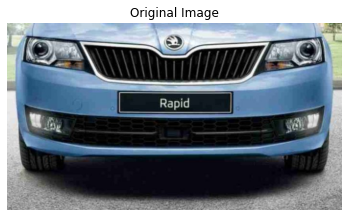

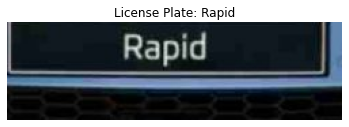

In [125]:
PAD = 0.05

img = cv2.cvtColor(cv2.imread("images/" + df_test.image_name[4]), cv2.COLOR_BGR2RGB)
orig = img.copy()

img = cv2.resize(img, dsize=(SIZE, SIZE))
y_hat = model.predict(img.reshape(1, SIZE, SIZE, 3) / 255)[0] #* SIZE

h, w = orig.shape[:2]

startX, startY = ceil(y_hat[0] * w), ceil(y_hat[1] * h)
endX, endY = ceil(y_hat[2] * w), ceil(y_hat[3] * h)

padX = ceil((endX - startX) * PAD)
padY = ceil((endY - startY) * PAD)

startX = max(0, startX - padX)
startY = max(0, startY - padY)
endX = min(w, endX + padX)
endY = min(h, endY + padY)

# orig = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 1)
# orig = cv2.rectangle(orig, (startX - padX, startY - padY), (endX + padX, endY + padY), (0, 255, 0), 1)
img = orig[startY:endY, startX:endX]

txt = pytesseract.image_to_string(cv2.resize(img, (int(img.shape[1] * 1.5), img.shape[0])), lang='eng', config='--psm 6')
txt = re.sub('[^a-zA-Z0-9\- ]', '', txt).strip()

plt.axis('off')
plt.title('Original Image')
plt.imshow(orig)
plt.show()

plt.axis('off')
plt.title(f'License Plate: {txt}')
plt.imshow(img)
plt.show()